In [1]:
import pandas as pd
import numpy as np

# Hela ML libraries 
from hela import hmm
import hela.generation.hmm as hmm_gen

# Viz libraries
import altair as alt
import hela.visualization.hmm as hmmplot 
import matplotlib.pyplot as plt
from hela.visualization.hmm import TU_COLORS
%matplotlib inline

# Utility Libraries
from datetime import datetime
from dask.distributed import Client
from scipy.special import logsumexp
from scipy import stats
import itertools
from IPython.display import Image

# PGMPy
from hela.graphical_hmm import DynamicBayesianNetwork as dbn
from hela.graphical_hmm.ContinuousFactor import ContinuousFactor
# from pgmpy.factors.discrete import TabularCPD
import networkx as nx


/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### HMM Generative Model

In [2]:
generative_model = hmm_gen.DiscreteHMMGenerativeModel(
                                     n_hidden_states =3,
                                     n_gaussian_features=0,
                                    n_categorical_features = 2,
                                     n_gmm_components = None)

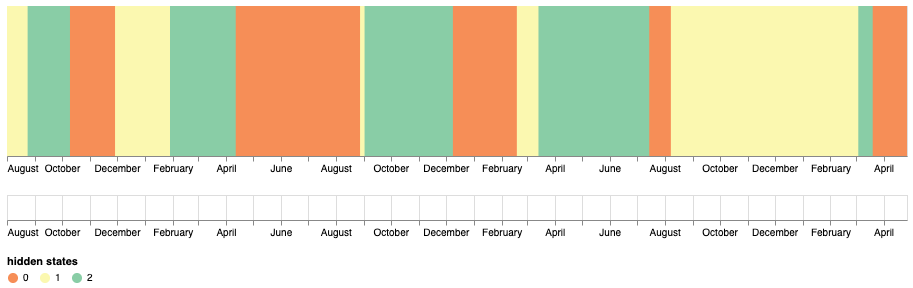

In [3]:
hidden_states = generative_model.generate_hidden_state_sequence(n_observations = 1000)
hmmplot.draw_states(hidden_states, hide_brush=False)

In [4]:
hmm_data = generative_model.generate_observations(hidden_states)
hmm_training_spec = generative_model.generative_model_to_discrete_hmm_training_spec()
model_config = hmm.DiscreteHMMConfiguration.from_spec(hmm_training_spec)
hmm_model = model_config.to_model()

In [5]:
hmm_graph = dbn.hmm_model_to_graph(hmm_model)

In [6]:
for node in hmm_graph.nodes:
    print("latent status for node {} at t = {}: ".format(node[0], node[1]), 
          hmm_graph.nodes[node])

latent status for node hs at t = 0:  {'latent': True}
latent status for node hs at t = 1:  {'latent': True}
latent status for node cat_obs at t = 0:  {'latent': False}
latent status for node cat_obs at t = 1:  {'latent': False}


In [7]:
hmm_graph.get_factors(time_slice=0)

[[<TabularCPD representing P(('cat_obs', 0):6 | ('hs', 0):3) at 0x7ff8798ce080>],
 [<TabularCPD representing P(('hs', 0):3) at 0x7ff90c271400>]]

In [8]:
hmm_graph.get_factors(time_slice=1)

[[<TabularCPD representing P(('cat_obs', 1):6 | ('hs', 1):3) at 0x7ff8798ce208>],
 [<TabularCPD representing P(('hs', 1):3 | ('hs', 0):3) at 0x7ff8798ce0f0>]]

In [9]:
# This checks that the CPD tables between edges are valid

hmm_graph.check_model()

True

In [10]:
hmm_graph.edges()

OutEdgeView([(('hs', 0), ('hs', 1)), (('hs', 0), ('cat_obs', 0)), (('hs', 1), ('cat_obs', 1))])

/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


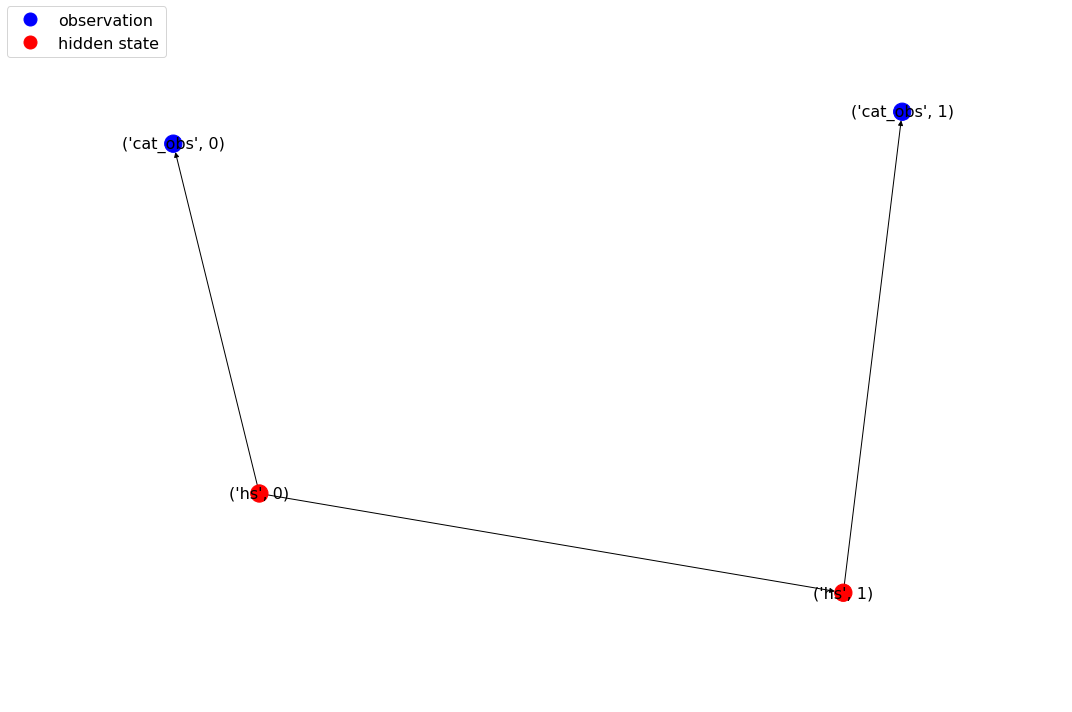

In [11]:
# Initialize Matplotlib figure and set figsize
f = plt.figure(1, figsize = (15,10))
ax = f.add_subplot(1,1,1)
plt.axis('off') # Turn off axis.

pos = nx.spring_layout(hmm_graph, k=5)

color_map = []
for n in hmm_graph.nodes:
    if "hs" in n[0]:
        color_map.append('red')
    else:
        color_map.append('blue')
    
nx.draw_networkx(hmm_graph, 
                 pos = pos, 
                 edge_color = "black", 
                 node_color = color_map,
                 with_labels=True, 
                 font_size = 16, 
                 node_size = 300)

ax.plot([],[],color="blue",label='observation', marker = 'o', markersize = 13, linewidth = 0)
ax.plot([],[],color="red",label='hidden state', marker = 'o', markersize = 13, linewidth = 0)
plt.legend()
plt.legend(loc='upper left', borderaxespad=0, fontsize = 16)
    

ax.set_xlim([1.2*x for x in ax.get_xlim()])
ax.set_ylim([1.2*y for y in ax.get_ylim()])
plt.tight_layout()
    
plt.show()

### FHMM

In [12]:
gen = hmm_gen.FactoredHMMGenerativeModel(
                                     ns_hidden_states =[3, 2],
                                     n_gaussian_features = 1,
                                     n_categorical_features = 2)

factored_hidden_states = gen.generate_hidden_state_sequence(n_observations = 500)

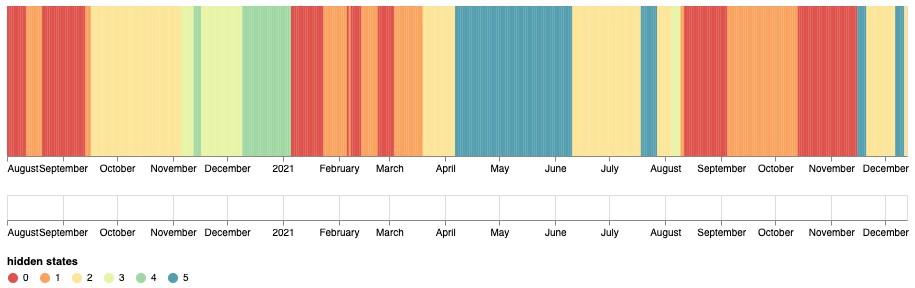

In [13]:
flattened_hidden_states = gen.flatten_hidden_state_sequence(factored_hidden_states)
hmmplot.draw_states(flattened_hidden_states, hide_brush=False)

In [56]:
type(flattened_hidden_states)

pandas.core.series.Series

In [14]:
data = gen.generate_observations(factored_hidden_states)
fhmm_training_spec = hmm_gen.data_to_fhmm_training_spec(factored_hidden_states, 
                                   gen.ns_hidden_states, 
                                   data,
                                   categorical_features = list(gen.categorical_values.columns), 
                                   gaussian_features = list(gen.gaussian_values.columns))

fhmm_config = hmm.FactoredHMMConfiguration.from_spec(fhmm_training_spec)
fhmm_model = fhmm_config.to_model()

In [15]:
# fhmm_graph = dbn.fhmm_model_to_graph(fhmm_model)
# for node in fhmm_graph.nodes:
#     print("latent status for node {} at time step {}: ".format(node[0], node[1]), 
#           fhmm_graph.nodes[node])
# fhmm_graph.edges()
# fhmm_graph.check_model()
# fhmm_graph.get_factors(time_slice=0)
# fhmm_graph.get_factors(time_slice=1)

In [16]:
# # Initialize Matplotlib figure and set figsize
# f = plt.figure(1, figsize = (15,10))
# ax = f.add_subplot(1,1,1)
# plt.axis('off') # Turn off axis.


# pos = nx.spring_layout(fhmm_graph, k=5)

# color_map = []
# for n in fhmm_graph.nodes:
#     if "system" in n[0]:
#         color_map.append('red')
#     else:
#         color_map.append('blue')
    
# nx.draw_networkx(fhmm_graph, 
#                  pos = pos, 
#                  edge_color = "black", 
#                  node_color = color_map,
#                  with_labels=True, 
#                  font_size = 16, 
#                  node_size = 300)

# ax.plot([],[],color="blue",label='observation', marker = 'o', markersize = 13, linewidth = 0)
# ax.plot([],[],color="red",label='hidden state', marker = 'o', markersize = 13, linewidth = 0)
# plt.legend()
# plt.legend(loc='upper left', borderaxespad=0, fontsize = 16)
    

# ax.set_xlim([1.2*x for x in ax.get_xlim()])
# ax.set_ylim([1.2*y for y in ax.get_ylim()])
# plt.tight_layout()
    
# plt.show()

In [17]:
from hela.graphical_hmm import structured_inference as dbn_inf
# hmm_graph.initialize_initial_state()


In [18]:
dbn_inf = dbn_inf.DBNInference(hmm_graph)

In [19]:
dbn_inf.out_clique

(('hs', 1), ('cat_obs', 1))

In [20]:
dbn_inf.in_clique

(('hs', 1), ('hs', 0))

In [37]:
from pgmpy.inference import VariableElimination
inference = VariableElimination(hmm_graph)
# ev_dict = {('hs', 1): 1, ('cat_obs', 0): (1,2)}
# inference.query([('hs', 0)], evidence = ev_dict, joint=True)
working_factors = {
    node: {(factor, None) for factor in inference.factors[node]}
    for node in inference.factors
}
working_factors

{}

In [38]:
inference.factors

defaultdict(list, {})

In [ ]:
# Step 2: Prepare data structures to run the algorithm.
eliminated_variables = set()
# Get working factors and elimination order
working_factors = inference._get_working_factors(ev_dict)
elimination_order = inference._get_elimination_order(
    variables, ev_dict, elimination_order, show_progress=show_progress
)

In [34]:
ev_dict = {('hs', 1): 1, ('cat_obs', 0): (1,2)}
inference.query([('hs', 0)], evidence = ev_dict, joint=True)

KeyError: ('hs', 1)

In [33]:
ev_dict = {('cat_obs', 0): (1,2), ('cat_obs', 1):( 0,0)}
dbn_inf.forward_inference([('hs', 2)], ev_dict)

ValueError: Values array must be of size: 3

In [ ]:
print(
hmm_graph.nodes

In [ ]:
hmm_data.head

In [ ]:
# dbn_inf.forward_inference([('X', 2)], {('Y', 0):1, ('Y', 1):0, ('Y', 2):1})[('X', 2)].values
# list of variables for which you want to compute the probability [('X', 2)] 
# evidence: dict a dict key, value pair as {var: state_of_var_observed}: {('Y', 0):1, ('Y', 1):0, ('Y', 2):1}
        

In [ ]:
print(hmm_graph.get_factors(('hs', 0))[0])

In [54]:
ev_dict = {('cat_obs', 0): (1,2), ('cat_obs', 1):(0,0), ('cat_obs', 2):(0,0) }
dbn_inf.forward_inference([('hs', 2)], ev_dict)

ValueError: Values array must be of size: 3

In [40]:
from collections import defaultdict
from itertools import tee, chain, combinations

from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.models import BayesianModel
from pgmpy.factors import factor_product
from pgmpy.inference import Inference, BeliefPropagation

In [41]:
variables = [('hs', 1)]
evidence = {('hs', 0): 1, ('cat_obs', 0): (1,2), ('cat_obs', 1):(0,0)}
variable_dict = defaultdict(list)
for var in variables:
    variable_dict[var[1]].append(var)
print(variable_dict)

defaultdict(<class 'list'>, {1: [('hs', 1)]})


In [42]:
time_range = max(variable_dict)
print(time_range)
if evidence:
    evid_time_range = max([time_slice for var, time_slice in evidence.keys()])
    time_range = max(time_range, evid_time_range)
print(evid_time_range)
print(time_range)

1
1
1


In [43]:
self = dbn_inf
print(self.start_junction_tree.factors[0])
print(self.one_and_half_junction_tree.factors[0])

+--------------+-------------------+---------------------------------+
| ('hs', 0)    | ('cat_obs', 0)    |   phi(('hs', 0),('cat_obs', 0)) |
+==============+===================+=================================+
| ('hs', 0)(0) | ('cat_obs', 0)(0) |                          0.0000 |
+--------------+-------------------+---------------------------------+
| ('hs', 0)(0) | ('cat_obs', 0)(1) |                          0.0000 |
+--------------+-------------------+---------------------------------+
| ('hs', 0)(0) | ('cat_obs', 0)(2) |                          0.0000 |
+--------------+-------------------+---------------------------------+
| ('hs', 0)(0) | ('cat_obs', 0)(3) |                          0.0000 |
+--------------+-------------------+---------------------------------+
| ('hs', 0)(0) | ('cat_obs', 0)(4) |                          0.0000 |
+--------------+-------------------+---------------------------------+
| ('hs', 0)(0) | ('cat_obs', 0)(5) |                          0.0000 |
+-----

In [44]:
start_bp = BeliefPropagation(self.start_junction_tree)
mid_bp = BeliefPropagation(self.one_and_half_junction_tree)
evidence_0 = self._get_evidence(evidence, 0, 0)
interface_nodes_dict = {}
potential_dict = {}
print(evidence_0)

{('hs', 0): 1, ('cat_obs', 0): (1, 2)}


In [45]:
if evidence:
    interface_nodes_dict = {
        k: v for k, v in evidence_0.items() if k in self.interface_nodes_0
    }
print(interface_nodes_dict)
print(self.interface_nodes_0)

{('hs', 0): 1}
[('hs', 0)]


In [46]:
initial_factor = self._get_factor(start_bp, evidence_0)
print(start_bp.junction_tree.get_factors()[0])
print(initial_factor) # not correct phi?
print(evidence_0)

+---------+
|   phi() |
+=========+
|  0.0003 |
+---------+
+---------+
|   phi() |
+=========+
|  0.0003 |
+---------+
{('hs', 0): 1, ('cat_obs', 0): (1, 2)}


In [50]:
initial_factor.scope()

[]

In [51]:
self.interface_nodes_0

[('hs', 0)]

In [48]:
marginalizing_nodes = list(set(initial_factor.scope()).difference(self.interface_nodes_0)) # []
print(marginalizing_nodes)
marginalized_factor = self._marginalize_factor(
    self.interface_nodes_0, initial_factor
)

[]


ValueError: Values array must be of size: 1

In [ ]:
# if evidence:
#     interface_nodes_dict = {
#         k: v for k, v in evidence_0.items() if k in self.interface_nodes_0
#     }
# initial_factor = self._get_factor(start_bp, evidence_0)
# marginalized_factor = self._marginalize_factor(
#     self.interface_nodes_0, initial_factor
# )
# potential_dict[0] = marginalized_factor
# self._update_belief(mid_bp, self.in_clique, marginalized_factor)

# if variable_dict[0]:
#     factor_values = start_bp.query(
#         variable_dict[0], evidence=evidence_0, joint=False
#     )
# else:
#     factor_values = {}

# for time_slice in range(1, time_range + 1):
#     evidence_time = self._get_evidence(evidence, time_slice, 1)
#     if interface_nodes_dict:
#         evidence_time.update(interface_nodes_dict)

#     if variable_dict[time_slice]:
#         variable_time = self._shift_nodes(variable_dict[time_slice], 1)
#         new_values = mid_bp.query(
#             variable_time, evidence=evidence_time, joint=False
#         )
#         changed_values = {}
#         for key in new_values.keys():
#             new_key = (key[0], time_slice)
#             new_factor = DiscreteFactor(
#                 [new_key], new_values[key].cardinality, new_values[key].values
#             )
#             changed_values[new_key] = new_factor
#         factor_values.update(changed_values)

#     clique_phi = self._get_factor(mid_bp, evidence_time)
#     out_clique_phi = self._marginalize_factor(
#         self.interface_nodes_1, clique_phi
#     )
#     new_factor = self._shift_factor(out_clique_phi, 0)
#     potential_dict[time_slice] = new_factor
#     mid_bp = BeliefPropagation(self.one_and_half_junction_tree)
#     self._update_belief(mid_bp, self.in_clique, new_factor)

#     if evidence_time:
#         interface_nodes_dict = {
#             (k[0], 0): v
#             for k, v in evidence_time.items()
#             if k in self.interface_nodes_1
#         }
#     else:
#         interface_nodes_dict = {}

# if args == "potential":
#     return potential_dict

# return factor_values